<a href="https://colab.research.google.com/github/ctclumak/Tensorflow-2-and-Keras-Deep-Learning/blob/master/RNN_on_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv("RSCCASN.csv", parse_dates=True,index_col='DATE')

In [3]:
df.info() # this shows the date is in string, we need to change it to datetime stamp, we use parse_dates = True to change string to Datime, and use index_col = "DATE" to set date as index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [0]:
# rename to columne to be sales 
df.columns=["Sales"]

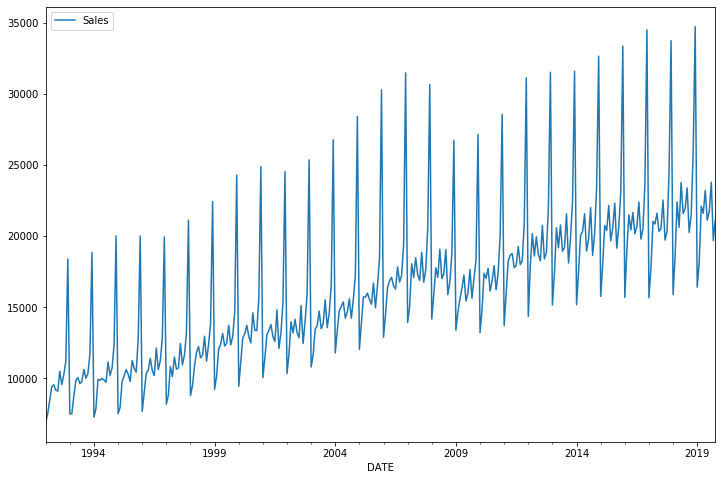

In [6]:
df.plot(figsize=(12,8))

In [7]:
# train test split
# since it is yearly cycle, we need to do at least 1 year test data, we will do 1.5 years here


#first,check the data length
len(df)

334

In [8]:
# the index is in month, so 1.5 year is 18 month
len(df)- 18

316

In [0]:
test_size = 18
test_ind = len(df) - test_size

In [0]:
# define the training and the test data set
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fit the training data to the scaler (we only fit the train data)
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# transform the scaled training data and test data to create the scale version of the training data 
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
# import the time series generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# because we will add an early stopping and an evaluation generator
# we will make sure the actual length of the batch is less than the length of the test set
# so the batch should be less than 18
len(scaled_test), len(scaled_test)

(18, 18)

In [0]:
# this represents the length of the actual batches
length = 12
batch_size = 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length= length, batch_size = batch_size)

In [0]:
X,y = generator[0]

In [0]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [17]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation = "relu", input_shape = (length,n_features)))
# the input_size = length*n_features
model.add(Dense(1))

model.compile(optimizer="adam", loss = 'mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# create an early stopping callback

from tensorflow.keras.callbacks import EarlyStopping
#patience is the number of epochs with no improvement after which training will be stopped
#the default patience is 0, but it might be too soon, so we set it to 2 to wait for at least 2 epochs
early_stop = EarlyStopping(monitor = "val_loss", patience = 2)

In [0]:
#create validation generator
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size = batch_size)

In [21]:
# fit the generator and train the model
model.fit_generator(generator, epochs=20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
304/304 [==============================] - 7s 22ms/step - loss: 0.0257 - val_loss: 0.0058
Epoch 2/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0189 - val_loss: 0.0054
Epoch 3/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 4/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0074 - val_loss: 0.0010
Epoch 5/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0036 - val_loss: 0.0237
Epoch 6/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0021 - val_loss: 7.1085e-04
Epoch 7/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 8/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0014 - val_loss: 0.0020


In [0]:
# visulize the losses
losses = pd.DataFrame(model.history.history)

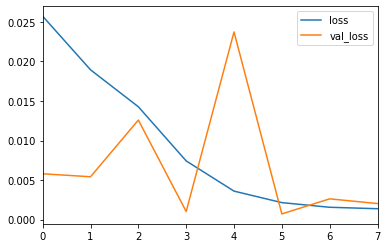

In [23]:
losses.plot()

In [0]:
# check how to test data perform
## set the test prediction as an empty list
test_predictions = []
# the first evaluation batch is the very last batch of the training set
# if the length is 12, then this means i will get the last 12 month of the training set
# to predict one month into the future
first_eval_batch = scaled_train[-length:]
# then we need to reshape the first evaluation batch to the correct format that is expected by RNN
# 1 means 1 item per batch, length is 12 month
current_batch = first_eval_batch.reshape((1,length,n_features))

#loop around the entire length of the test set
for i in range(len(test)):
  # get the prediction 1 time stamp ahead [0] is for just grasping the number index
  current_pred = model.predict(current_batch)[0]
  #append the current prediction to test prediction
  test_predictions.append(current_pred)
  #update the batch to now include prediction and drop first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)


In [0]:
# inverse transform the test prediction
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22115.316945
2018-06-01,21589,20879.372815
2018-07-01,21919,21210.233119
2018-08-01,23381,23182.935696
2018-09-01,20260,20575.937951
2018-10-01,21473,21376.222286
2018-11-01,25831,25618.178445
2018-12-01,34706,36460.227067
2019-01-01,16410,16348.947167


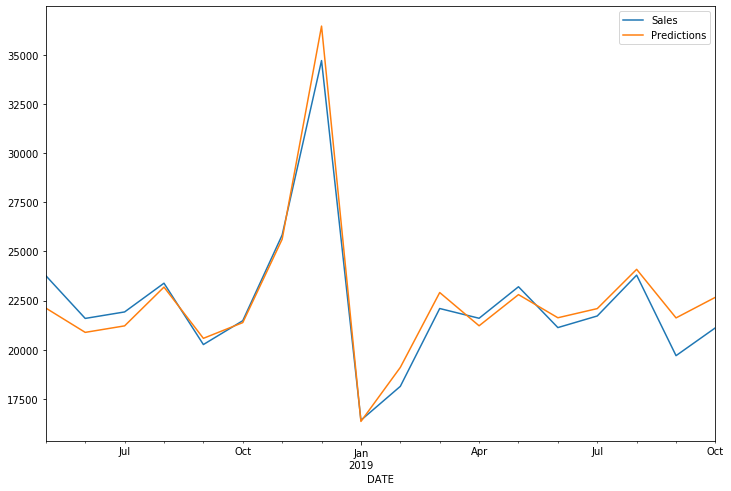

In [29]:
test.plot(figsize = (12,8))

In [0]:
# forcast
# first, scaler the data, fit transform the whole data frame
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [0]:
#create teh generator
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [33]:
# create the model
model = Sequential()
model.add(LSTM(100,activation = "relu", input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

#fit the generator
# we choose 8 as epochs here is because the earlystopping was satisfied by our validation loss
model.fit_generator(generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 6s 20ms/step - loss: 0.0246
Epoch 2/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0181
Epoch 3/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0102
Epoch 4/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0059
Epoch 5/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0026
Epoch 6/8
322/322 [==============================] - 5s 16ms/step - loss: 0.0028
Epoch 7/8
322/322 [==============================] - 5s 17ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 5s 17ms/step - loss: 0.0014


In [0]:
# forcast into the future
forecast = []
periods = 12
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(periods):
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]],axis = 1)

In [0]:
#inverse scaler our forcast
forecast = scaler.inverse_transform(forecast)


In [39]:
forecast

array([[25194.25716591],
       [35504.82687664],
       [16378.51344895],
       [17732.31308889],
       [20969.9137044 ],
       [20653.58289146],
       [22148.81193495],
       [20455.5475781 ],
       [21020.57155275],
       [22905.82629824],
       [19443.30342412],
       [20680.78259015]])

In [0]:
# add a timestamp for the forecast value
forecast_index = pd.date_range(start = "2019-11-01",periods = periods, 
                               freq='MS') #MS IS MONTHLY START

In [42]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index,
                           columns = ['Forecast'])

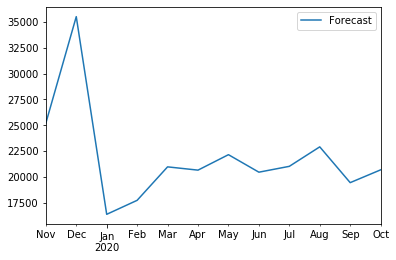

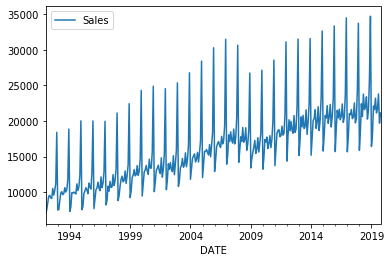

In [45]:
forecast_df.plot()
df.plot()

(576, 611)

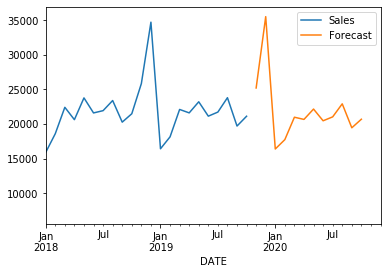

In [47]:
# or you can put them in the same plot
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01", '2020-12-01')  # xlim is used for zoom in